In [30]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle

import swimAD2 as ad2       
import time
import dwfconstants as dwfc

ad2.disconnect()            
zoroku = ad2.connect(0)      #彼は老人
alice = ad2.connect(1)

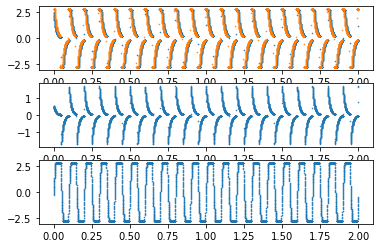

In [56]:
def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        return size,hertz
    
size,rate = sampling(2)
    
rng = 5
for swim in [zoroku,alice]:
    ad2.config_oscilloscope(swim,
        range0=rng,
        range1=rng,
        sample_rate = rate,
        sample_size= size,
        )

ad2.config_wavegen(zoroku, 
        frequency=10,
        amplitude=5,
        signal_shape=dwfc.funcSquare
        )

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.1)

t0,ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
t1,ch2,ch3 = ad2.measure_oscilloscope(alice)

ad2.stop_wavegen(zoroku,channel=0)
ad2.reset_wavegen(zoroku,channel=0)

fig,axs=plt.subplots(3,1)
axs[0].scatter(t0,Ch2,s=0.3)
axs[0].scatter(t1,ch2,s=0.3)
axs[1].scatter(t0,ch1,s=0.3)
axs[2].scatter(t1,ch3,s=0.3)

plt.show()

In [1]:
# Test by first bringing backwards. 
# If fails, test forwards. 
def find_times(Ch2,ch2):
    backward,forward = [],[]
    for i in range(100):
        backward.append(np.mean(Ch2[i:]-ch2[:i]))
        forward.append(np.mean(ch2[i:]-Ch2[:i]))

    score_back = np.min(backward)
    score_forw = np.min(forward)

    if score_back > score_forw:
        print(np.argmin(forward))
        i = np.argmin(forward)
        direction = "for"
    else: 
        print(np.argmin(backward))
        i = np.argmin(backward) 
        direction = "bac"
    return i, direction

def sync_series(t0,ch1,Ch2,ch2,ch3):
    i,dir = find_times(Ch2,ch2)
    if dir=="bac":
        return t0[:i],ch1[:i],ch2[i:],ch3[i:]
    else: 
        return t0[i:],ch1[i:],ch2[:i],ch3[:i]

NameError: name 't0' is not defined